# BASICS OF MOBILE ROBOTICS
## BOMR Project

This project was made by the Group 31, made up of the following people:

### Axel Béguelin, Lou De Bel-Air, Robin Carlet, Robin Junod.

For this project of mobile robotics, we were asked to use a ThymioII robot, a camera and our project had to use the following concepts:

- Vision
- Global Navigation
- Motion Control
- Filtering
- Local Navigation

Just a quick resume of the robot. Thymio II is an educational robot in the 100 Euros price range. The robot was developed at the EPFL in collaboration with ECAL, both in Lausanne, Switzerland (wiki source). This robot has the following features:

- 2 DC-motors (and 2 Wheels)
- 39 leds
- 1 loud speaker

and has the following sensor:
- 9 infrared (IR) proximity sensors (reach about 10cm)
- 5 capacitive touch buttons
- 1 three-axis accelerometer
- 1 thermometer
- 1 microphone (recording or detection of noise)
- 1 IR receiver (for remote controller)
- 1 Wireless module

![SNOWFALL](img_presentation/img_thymio.png)

# Introduction of our project

We decided to choose the follwing project with the following setup. The goal of the thymio is to go from any position on a map to an objective.

## GLOBAL NAVIGATION

We choosed to use visibility graphs, we then apply a shortest path algorithm on it (A*). To do so a class Global_Navigation is implemented.

In [1]:
class Global_Navigation:
    def __init__(self,obstacles_pos,thymio_pos,goal_pos,map_size):            
        #convert the obstacle_pos as list of lists of tuples instead list of np.ndarray of tuples for next calculations
        self.all_obstacles=[]
        for index, obstacle in enumerate(obstacles_pos):
            self.all_obstacles.append([])
            for point in obstacle:
                self.all_obstacles[index].append((point[0],point[1]))
            
        self.raw_obstacles_pos=obstacles_pos
        self.thymio_pos=(thymio_pos[0],thymio_pos[1])
        self.goal_pos=(goal_pos[0],goal_pos[1])
        self.all_nodes=[]
        self.all_nodes.append(self.thymio_pos)
        self.all_nodes.append(self.goal_pos)      
        for obstacle in self.all_obstacles:
            for node in obstacle:
                self.all_nodes.append((node[0],node[1]))
        
        self.max_valx=map_size[0]
        self.max_valy=map_size[1]
        self.nodes_neigbors={}
        self.path=[]

Objects of this class take as parameters the state of the map: position of the thymio, the goal and the obstacles that have been already virtualy expanded to make sure that the thymio does not collide with obstacles, and the size of the map.

#### Visibility graph

First of all, in order to create visibility graph, we defines, position of the thymio, 
goal and vertices (that are not too closed to the edges of the map) of the obstacles as nodes of the graph.

Then we construct links between the nodes that are not obstructed by obstacles.
To do so we distinct to cases: <br />
-create links between nodes that are not vertices of the same obstacle <br />
-create links between nodes that are vertices of the same obstacle <br />

##### Nodes that are not vertices of the same obstacle

In [2]:
def onSegment(self,p, q, r):
    if ( (q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and 
           (q[1] <= max(p[1], r[1])) and (q[1] >= min(p[1], r[1]))):
        return True
    return False

Global_Navigation.onSegment = onSegment

def orientation(self,p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise
    val = (float(q[1] - p[1]) * (r[0] - q[0])) - (float(q[0] - p[0]) * (r[1] - q[1]))
    if (val > 0):
        # Clockwise orientation
        return 1
    elif (val < 0):
        # Counterclockwise orientation
        return 2
    else:
        # Collinear orientation
        return 0

Global_Navigation.orientation = orientation
  
def doIntersect(self,p1,q1,p2,q2):

    # Find the 4 orientations required for 
    # the general and special cases
    o1 = self.orientation(p1, q1, p2)
    o2 = self.orientation(p1, q1, q2)
    o3 = self.orientation(p2, q2, p1)
    o4 = self.orientation(p2, q2, q1)

    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True
    # Special Cases

    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and self.onSegment(p1, p2, q1)):
        return True

    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and self.onSegment(p1, q2, q1)):
        return True

    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and self.onSegment(p2, p1, q2)):
        return True

    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and self.onSegment(p2, q1, q2)):
        return True

    # If none of the cases
    return False

Global_Navigation.doIntersect = doIntersect

For each pair of two nodes we look if any edges of every obstacles obstruct the creation a link between the nodes of this pair.
To do so in the implementation of this algorithm, the use the code for segments intersection detection of geeksforgeeks https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/ , that rely on the orientations of three given points in a certain order. If there is any intersection, any link is created, and we look for the feasibility of a link between the next pair of nodes.

##### Nodes that are vertices of the same obstacle

For nodes that are vertices of the same obstacle, looking at intersections does not work as we can see in the following example:

![first image global nav](img_presentation/imageglobnav1.png)

We can see on the figure above that the segment formed with the two nodes specified by the red circles has no intersection with any other segment, however the thymio obviously can't travel from one to the other because the obstacle is between them, hence the need of using an other method for this case.

![second image global nav](img_presentation/imageglobnav2.png)

The figure above all the possibles orientations of: <br />
-the node 1, the node 2, and the node before the node 1 in the list of the obstacle (the vertices of the obstacle are sorted in the corresponding so their index are following the exterior contour in a "counter-clockwise" fashion)  <br />
-the node 1, the node 2, and the node after the node 1 in the list of the obstacle  <br />
-the node 1, the node after the node 1 in the list of the obstacle, and the node before the node 1 in the list of the obstacle <br />

(Note that we can define node 1 and node 2 interchangeably, it doesn't matter they are just the nodes of the paire of nodes that we want to check the feasibility of creating a link). <br />

We only have to look to the orientation between the gray line and the directs neighbor vertices because we are in the cases of the second lines, and if it happens that further edges cross the gray line, it will be detected by the segments intersection function previously seen, thus no lines link between the pair of nodes will be created. In the cases where some of the 3 orientations we look happened to be colinear, it will also be handled by the segment intersections function.

Thus, on the figure above we can easily deduce the combination of the three orientations leading to the unfeasibility of creating a link for the pair of nodes (the obstacle is between the two nodes) corresponding of the 4 cases of the first link, that is implemented inside the following function "find_neighbors".

In [3]:
def find_neighbors(self,all_obstacles,all_nodes,pos_thymio,goal):


    neighbors = {node: [] for node in all_nodes}


    #if the nodes of obstacles are too close from the edges of the maps, don't add them to the visiblity graph
    nodes_close_edges=[]
    for obstacle in all_obstacles:
        for node in obstacle:
            if (node[0]< 38) or (node[0]> self.max_valx-38) or (node[1]<38) or (node[1]>self.max_valy-38):
                nodes_close_edges.append(node)
                
    for i in range(len(all_nodes)): 
        if all_nodes[i] in nodes_close_edges:
            continue
        for j in range(len(all_nodes) - i - 1):

            intersection=False

            if all_nodes[i+j+1] in nodes_close_edges:
                continue

            tmp_link1=[all_nodes[i],all_nodes[i+j+1]]

            for obstacle in all_obstacles:

                #identify when 2 vertices of the same polygon are connected
                if (all_nodes[i] in obstacle) and (all_nodes[i+j+1] in obstacle): 
                    if obstacle.index(all_nodes[i])==len(obstacle)-1:
                        if (obstacle.index(all_nodes[i+j+1]) != 0) and (obstacle.index(all_nodes[i])!=obstacle.index(all_nodes[i+j+1])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[0])
                            o3=self.orientation(all_nodes[i],obstacle[0],obstacle[obstacle.index(all_nodes[i])-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break
                    elif obstacle.index(all_nodes[i])==0:
                        if (obstacle.index(all_nodes[i+j+1]) != len(obstacle)-1) and (obstacle.index(all_nodes[i+j+1]) != obstacle.index(all_nodes[i])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[len(obstacle)-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])+1])
                            o3=self.orientation(all_nodes[i],obstacle[obstacle.index(all_nodes[i])+1],obstacle[len(obstacle)-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break
                    else:
                        if (obstacle.index(all_nodes[i])!=obstacle.index(all_nodes[i+j+1])+1) and (obstacle.index(all_nodes[i+j+1]) != obstacle.index(all_nodes[i])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])+1])
                            o3=self.orientation(all_nodes[i],obstacle[obstacle.index(all_nodes[i])+1],obstacle[obstacle.index(all_nodes[i])-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break   

                #implement the segment intersection function between the current pair of nodes and all the edges of all the obstacles
                for index, vertice in enumerate(obstacle):

                    if index== len(obstacle)-1: #last point of the obstacle
                        tmp_link2=[(vertice[0],vertice[1]),(obstacle[0][0],obstacle[0][1])]
                    else:

                        tmp_link2=[(vertice[0],vertice[1]),(obstacle[index+1][0],obstacle[index+1][1])]


                    if tmp_link1[0] ==tmp_link2[0] or tmp_link1[0] ==tmp_link2[1] or tmp_link1[1] == tmp_link2[0] or tmp_link1[1] ==tmp_link2[1]:
                        continue

                    if self.doIntersect(tmp_link1[0],tmp_link1[1],tmp_link2[0],tmp_link2[1]):
                        intersection=True
                        break

                if intersection==True:
                    break

            if intersection==False:
                neighbors[all_nodes[i]].append(all_nodes[i+j+1])
                neighbors[all_nodes[i+j+1]].append(all_nodes[i])

    return neighbors

Global_Navigation.find_neighbors = find_neighbors

#### Find the shortest path

The A* algorithm is implemented because compared to the dijkstra algorithm it happens to be much faster, need to visit much less nodes of the graph in order to find the right path.

In [4]:
def h_vertices_obstacles(self,coords,goal):
    k=[]
    for vertex in coords:
        k.append(math.dist(vertex,goal))
        h = dict(zip(coords, k))
    return h

Global_Navigation.h_vertices_obstacles = h_vertices_obstacles

The function above is in charge of defining the heuristic function as the distance from the nodes of the graph to the goal.

In [5]:
def reconstruct_path(self,cameFrom, current):

    total_path = [current] 

    while current in cameFrom.keys():

        total_path.insert(0, cameFrom[current])  
        current=cameFrom[current]

    return total_path

Global_Navigation.reconstruct_path = reconstruct_path

The function above return the list of nodes to go to a certain node from the goal, used to get the path to the goal in the A* algorithm 

In [6]:
def A_Star(self,start, goal, h_vertices_obstacles, coords, nodes_neigbors,max_valx,max_valy):


    for point in [start, goal]:
        assert point[0]>=0 and point[0]<max_valx and point[1]>=0 and point[1]<max_valy ,"start or end goal not contained in the map"


    openSet = [start]

    closedSet = []

    cameFrom = dict()

    gScore = dict(zip(coords, [np.inf for x in range(len(coords))])) 
    gScore[start] = 0 

    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = math.dist(goal,start)



    while openSet != []: 
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet 

        if current == goal:
            return self.reconstruct_path(cameFrom, current)

        openSet.remove(current)
        closedSet.append(current)

        for neighbor in nodes_neigbors[current]: 


            if (neighbor in closedSet): 
                continue


            tentative_gScore = gScore[current] + math.dist(current,neighbor) 

            if neighbor not in openSet:
                openSet.append(neighbor) 

            if tentative_gScore < gScore[neighbor]:
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h_vertices_obstacles[neighbor]


    print("No path found to goal")
    return [], closedSet

Global_Navigation.A_Star = A_Star

The A* is implemented in the function above, the weight to travel from one node to an otheris is the distance between these two nodes

In [7]:
def create_path(self):           
    self.nodes_neigbors=self.find_neighbors(self.all_obstacles,self.all_nodes,self.thymio_pos,self.goal_pos)

    self.path=self.A_Star(self.thymio_pos, self.goal_pos, self.h_vertices_obstacles(self.all_nodes,self.goal_pos), self.all_nodes,self.nodes_neigbors ,self.max_valx,self.max_valy)
    return self.path

Global_Navigation.create_path = create_path

The function above is the one used to obtaine the shortest path after having inialized an object of the class Global_Navigation.

#### Plots

In [8]:
def plot_visibility_graph(self):
    Img=np.zeros((self.max_valy, self.max_valx,3), dtype='uint8')

    for obstacle in self.raw_obstacles_pos:
        cv2.polylines(Img, [obstacle.reshape((-1, 1, 2))], True, (255,255,0), 5) 

    cv2.circle(Img, (round(self.goal_pos[0]),round(self.goal_pos[1])), 5, (255, 0, 0), 5)
    cv2.circle(Img, (round(self.thymio_pos[0]),round(self.thymio_pos[1])), 5, (0, 0, 255), 5)

    for node in self.nodes_neigbors:
        for neighbor in self.nodes_neigbors[node]:
            image = cv2.line(Img, (round(node[0]),round(node[1])), (round(neighbor[0]),round(neighbor[1])), (100, 100, 255), 2)
    plt.imshow(image) 
    
Global_Navigation.plot_visibility_graph = plot_visibility_graph

In [9]:
def plot_shortest_path(self):
    Img=np.zeros((self.max_valy, self.max_valx,3), dtype='uint8')
    for obstacle in self.raw_obstacles_pos:
        image = cv2.polylines(Img, [obstacle.reshape((-1, 1, 2))], True, (255,255,0), 5) 
    cv2.circle(Img, (round(self.goal_pos[0]),round(self.goal_pos[1])), 5, (255, 0, 0), 5)
    cv2.circle(Img, (round(self.thymio_pos[0]),round(self.thymio_pos[1])), 5, (0, 0, 255), 5)

    cv2.polylines(Img, np.int32([np.array(self.path).reshape((-1, 1, 2))]), False, (200, 0, 255), 3) 

    plt.imshow(image)
    
Global_Navigation.plot_shortest_path = plot_shortest_path

## MOTION CONTROL

For the motion control, we used a PID controller that was used to smooth the robot trajectory. This PID controller is working on the angle error between the direction of the robot and the goal direction. A PI controller would have been probabely sufficiant but we decided to use a PID to have more freedom for the tuning.

This PID controller is comparing the angle error and give as output a 'rotation' delta speed. This rotation speed will then be add/substated to the left and right motor speed. To have something has bellow:
<div>
<img src="img_presentation/pid_resume.png" width="300"/>
</div>

For the computation of the angle error, we need the follwing information:
- robot position
- angle of the robot
- goal position

We represent the postion in the classical cartesian coordinates (x,y). The angle of the thymio(alpha) and the angle of the goal(alpha_goal) as 'absolut angle'. The vector (1,0) has the angle 0 (the vector (0,1) as the angle pi/2 etc...). The angle is negative in clockwise direction. The angle error is always represented in the range : [-pi , pi], This way, the PID controller is easy to implement. The image below is presenting the general idea of the PID implementation:

<div>
<img src="img_presentation/PID_details.png" width="500"/>
</div>

The motion control part is made in a class of .py file. For further information, go look at the script: functiion.MotionControl.py.

In [10]:
import function.MotionControl as MotionControl
import matplotlib.pyplot as plt
import math

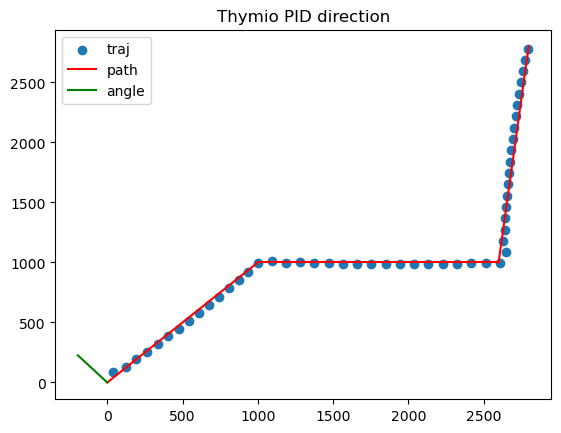

In [19]:
# Here is an exemple trajectory of the implemetation of the PID without the filtered feedback about the position and angle.
# For this exemple, we take only the 
# Here is an exemple trajectory of the implemetation of the PID without the filtered feedback about the position and angle.
# For this exemple, we take only the 

goals_list = [(1000,1000), (2600,1000),(2800,2800)]
n_goal = 0
goal_pos = list(goals_list[n_goal])

init_robot_angle = -4
robot_speed = [100,100]
robot_angle = -4
robot_pos = [0,0]

d_time = 3
thymio_trajectory = []

# Create PID controller
PID = MotionControl.MotionControl()
PID.update_angle_error(robot_angle, robot_pos, goals_list[n_goal])
# loop
loop = 0
while True:
    loop += 1
    goal_achieved = False
    # compute error
    PID.update_angle_error(robot_angle, robot_pos, goal_pos)
    # compute PID speed
    [robot_speed[0], robot_speed[1]] = PID.PID(d_time, 100, 100)
    # set speed and get new position and angle value
    [robot_pos[0], robot_pos[1], robot_angle] = PID.plant(robot_speed[0], robot_speed[1], robot_pos[0], robot_pos[1], robot_angle, d_time)
    thymio_trajectory.append((robot_pos[0], robot_pos[1]))
    
    # Check proximity
    dist_to_goal = (robot_pos[0]-goal_pos[0])**2 + (robot_pos[1]-goal_pos[1])**2
    if dist_to_goal < 400 or loop > 300:
        n_goal += 1
        if n_goal < len(goals_list):
            goal_pos = list(goals_list[n_goal])
            # reset integral value
            PID.PID_integral = 0
        else:
            break

# plot trajectorie
plt.scatter(*zip(*thymio_trajectory), label='thymio trajectory')
# Plot objective 'path'
# Plot objective 'path'
plt.plot([0,goals_list[0][0]], [0,goals_list[0][1]], color = 'red', linestyle = 'solid', label='path')

plt.plot([goals_list[0][0],goals_list[1][0]], [goals_list[0][1],goals_list[1][1]], color = 'red', linestyle = 'solid', label=None)
plt.plot([goals_list[1][0],goals_list[2][0]], [goals_list[1][1],goals_list[2][1]], color = 'red', linestyle = 'solid', label=None)

plt.plot([0,300*math.cos(init_robot_angle)], [0, 300 * math.sin(init_robot_angle)], color = 'green', label='starting angle')

plt.legend()
plt.title('Thymio PID direction')
plt.show()



# Threading and code organisation

We decided to use a threads for the data aquisition of the thymio. In this way we don't need to wait on the thymio for the information on the thymio speed and the sensors. Thoses computation can be done in parallel so we can compute simultaneously the vison/motioncontrol. 

The two threads we created are the following ones:
- thread_update_odometry 
- thread_get_sensor

The odomerty threads takes the values of the motors speed and compute the relative position/angle of the thymo. It then returns the results in the globa variables ODOMERTY. In this way, this Global variable will be updated and can be reused in other threads for other computation.

The get sensor thread is a simplier threads that only read the sensor values and returns it also in a global varaible (PROX_SENSOR). 

In that way we have 2 global variables that are updated and accecible at anytime.

We decided to use threads, because the reading variables for the sensor can take up to 100ms. If we had a all in a simple loop, this would make the whole programm wait for those sensor values.
The main thread is the loop in the main file. In this part we are computing the follwing parts: visualisation, filtering and the controller.


<div>
<img src="img_presentation/threads_.png" width="500"/>
</div>


# Odomerty

The odomerty part is a thread in the the following file : function/main.py.


As said before, we are computing the updating the odomerty in a threads and the result is saved into a gloval variable. Another thing to notice is that this global variable ODOMERTY is also update after the filtering. This means that this ODOMERTY variable doesn't rely only on the motor speed but is also modified by the vision. With this techinique the error of the odomerty is not incresing across time (it is when the odomertry is running on its own but is adjusted as soon as it goes into the filtering).

Now let's look the thread update odomerty into details. The goal here is to estimated the postition of the robot knowing the speed of the right and left motors. For this we made the follwing computation and hypothesis:

<div>
<img src="img_presentation/odometry.png" width="800" />
</div>


This computation of the odomerty relies only on speed of the right and left motors. Thus we have an error on the prediction of the postition that comes from the motor speed unperfect values. To correct this error, we will need a filter (for the moment, this error will increase across time because we are basically integrating speed). More inforamtions about this in part 'filtering'

# Filtering

The filter will help us have a better approximation of the thymio position. For this we will take the position given by the odomerty and the position given by the camera and use a fitler. The filter we are using is inspired by the kalmann filter but is a bit different as the computation for the estimated position is done in the odomerty thread and not in the filter. 

The filtering is composed of 2 filters. One is making the filering on the position by comparing the one of the odometry with the postiton given by the vision.
The second filter is doing the same thing but comparing the angle. Combining these 2 filters give us approximation on all the important variables. 

Once the filtering has finshed his computation, We gave the new values of the position and angle to the ODOMETRY global variable. This way the ODOMERTY has always the best approximation and the error will not increase across time (To be more precis,the error increase across time until the filtering gives new values. But as the filtering is often computed it's not a problem). With this technique we also solve the problem of kidnapping, meaning that we can move the robot at any place and the odomerty will be updated to track the robot again. Also when the wheels skid we won't loose track of the robot.

Here below is a representation of the thymio estimated position before and after the filtering:

In [13]:
# Here we present the estimated postition of the thymio before and after the filtering. For this we have recorded the estimeted postiton of the thymio.
import json
with open('img_presentation/ODOMETRY.txt', 'r') as f:
    LIST_ODO = json.loads(f.read())

import numpy as np
thymio_traj_points=np.array([np.array(x[0:2]) for x in LIST_ODO])
thymio_traj_points = np.transpose(thymio_traj_points)
thymio_traj_points

array([[ 65.63349917,  65.63349917,  65.63349917, ..., 391.00675674,
        391.9058683 , 392.6495354 ],
       [320.05721393, 320.05721393, 320.05721393, ..., 219.16560627,
        219.38248831, 219.56155774]])

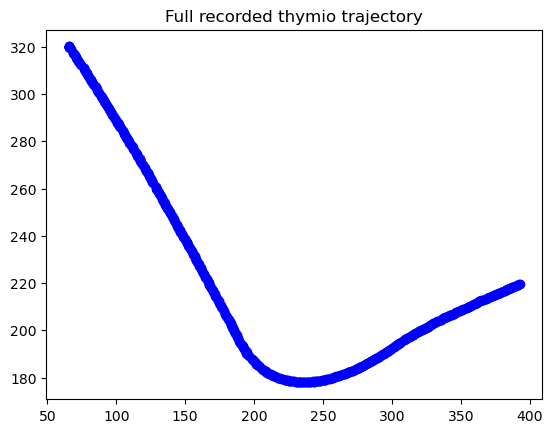

In [14]:
plt.title('Full recorded thymio trajectory')
plt.scatter(thymio_traj_points[0],thymio_traj_points[1], color='blue')
plt.show()

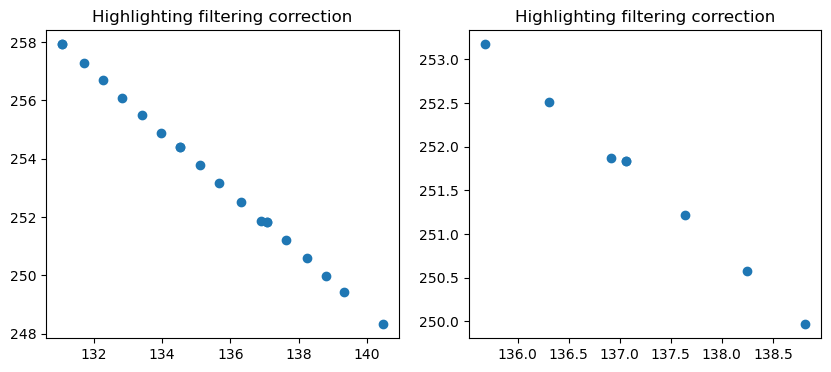

In [15]:
# here we will highlight the moment the filter is going to recompute the thymio postion
plt.figure(1,figsize=(10,4))

plt.subplot(121)
thymio_traj_points_ = thymio_traj_points[:,130:150]
plt.title('Highlighting filtering correction')
plt.scatter(thymio_traj_points_[0],thymio_traj_points_[1])

plt.subplot(122)
thymio_traj_points_ = thymio_traj_points[:,140:148]
plt.title('Highlighting filtering correction')
plt.scatter(thymio_traj_points_[0],thymio_traj_points_[1])


plt.show()

# We can see on near the region [137,252] 2 points being close to eachother. 
# we have here the filtering recomputing a better position for the thymio

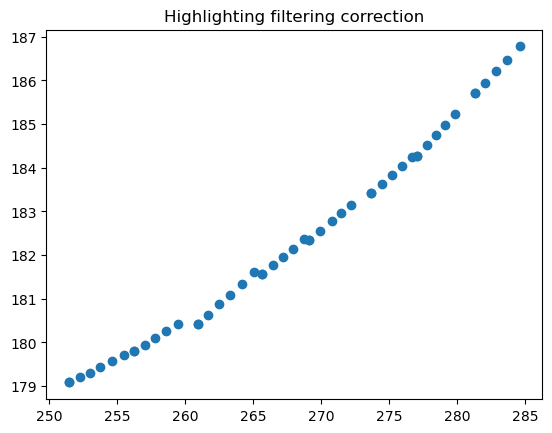

In [16]:
# Here is another place where the filtering can be seen
thymio_traj_points_ = thymio_traj_points[:,350:400]
plt.title('Highlighting filtering correction')
plt.scatter(thymio_traj_points_[0],thymio_traj_points_[1])
plt.show()


On the prevous graph we can see some position adjustement due to the filtering.
<div>
<img src="img_presentation/filter_results_2.png" width="400" />
</div>